In [5]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
from keras.losses import mean_squared_error
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2
import scipy.io as spio
import random

def pass_arg(nsim, tr_size, dropoutrate):
    print("Tr_size:", tr_size)
    def fix_seeds(seed):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # K.set_session(sess)
        tf.compat.v1.keras.backend.set_session(sess)

    ss = 1
    fix_seeds(ss)

    # MC dropout
    class MCDropout(Dropout):
        def call(self, inputs, training=None):
            return super(MCDropout, self).call(inputs, training=True)

    # Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

    # Making sure final porosity is less than initial
    def poros(poroi, porof):
        porofn = -porof*(porof<0)
        porofp = porof*(porof>=poroi) - poroi*(porof>=poroi)
        return porofp+porofn

    def phy_loss_mean(params):
        # useful for cross-checking training
        loss1, loss2, loss3, loss4, lam1, lam2 = params
        x1, x2, x3 = loss1*(loss1>0), loss2*(loss2>0), loss3*(loss3>0)
    #     print(np.mean(x1), x1.shape[0])
    #     print(np.mean(x2), x2.shape[0])
    #     print(np.mean(x3), x3.shape[0])

        if x1.any() and x1.shape[0]>1:
            X_scaled1 = (x1 - np.min(x1)) / (np.max(x1) - np.min(x1))
            x1 = X_scaled1
        if x2.any() and x2.shape[0]>1:
            X_scaled2 = (x2 - np.min(x2)) / (np.max(x2) - np.min(x2))
            x2 = X_scaled2
        if x3.any() and x3.shape[0]>1:
            X_scaled3 = (x3 - np.min(x3)) / (np.max(x3) - np.min(x3))
            x3 = X_scaled3
        return (lam1*np.mean(x1) + lam2*np.mean(x2) + lam2*np.mean(x3))
    #     return (lam1*np.mean(x1) + lam2*np.mean(x2) + lam2*np.mean(x3) + lam2*loss4)

    def PGNN_train_test(optimizer_name, optimizer_val, drop_rate, iteration, n_layers, n_nodes, tr_size, lamda, reg):

        # Hyper-parameters of the training process
        # batch_size = int(tr_size/2)
        batch_size = 1000
        num_epochs = 1000
        val_frac = 0.2
        patience_val = 100

        # Initializing results filename
        exp_name = optimizer_name + '_drop' + str(drop_rate) + '_nL' + str(n_layers) + '_nN' + str(n_nodes) + '_trsize' + str(tr_size) + '_iter' + str(iteration)
        exp_name = exp_name.replace('.','pt')
        results_dir = '../results/'
        model_name = results_dir + exp_name + '_NoPhyInfomodel.h5' # storing the trained model
        if reg:
            results_name = results_dir + exp_name + '_results_regularizer.dat' # storing the results of the model
        else:
            results_name = results_dir + exp_name + '_results.dat' # storing the results of the model

        #List of lakes to choose from
        lake = ['mendota' , 'mille_lacs']
        lake_num = 1  # 0 : mendota , 1 : mille_lacs
        lake_name = lake[lake_num]

        # Load features (Xc) and target values (Y)
        data_dir = '../../data/'
        filename = lake_name + '.mat'
        mat = spio.loadmat(data_dir + filename, squeeze_me=True,
        variable_names=['Y','Xc_doy','Modeled_temp'])
        Xc = mat['Xc_doy']
        Y = mat['Y']

        # normalize dataset with MinMaxScaler
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
        Xc = scaler.fit_transform(Xc)

        # train and test data
        trainX, trainY = Xc[:tr_size,:], Y[:tr_size]
        testX, testY = Xc[-1500:,:], Y[-1500:]

        # Creating the model
        model = Sequential()
        for layer in np.arange(n_layers):
            if layer == 0:
                model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
            else:
                if reg:
                    model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=.00, l2=.00)))
                else:
                    model.add(Dense(n_nodes, activation='relu'))
            model.add(MCDropout(rate=drop_rate))
        model.add(Dense(1, activation='linear'))

        model.compile(loss='mean_squared_error',
                      optimizer=optimizer_val,
                      metrics=[root_mean_squared_error])

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val,verbose=1)

        print('Running...' + optimizer_name)
        history = model.fit(trainX, trainY,
                            batch_size=batch_size,
                            epochs=num_epochs,
                            verbose=1,
                            validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])

        test_score = model.evaluate(testX, testY, verbose=1)
        print(test_score)

#         samples = []
        test_scores = []
        for i in range(int(nsim)):
#             print("simulation num:",i)
#             predictions = model.predict(testX)
#             samples.append(predictions)
            test_score = model.evaluate(testX, testY, verbose=0)
            test_scores.append(test_score[1])
        return np.array(test_scores), history



    # Main Function
    if __name__ == '__main__':

        fix_seeds(1)

        # List of optimizers to choose from    
        optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
        optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]

        # selecting the optimizer
        optimizer_num = 2
        optimizer_name = optimizer_names[optimizer_num]
        optimizer_val = optimizer_vals[optimizer_num]

        # Selecting Other Hyper-parameters
        drop_rate = dropoutrate # Fraction of nodes to be dropped out
        n_layers = 2 # Number of hidden layers
        n_nodes = 15 # Number of nodes per hidden layer

        tr_size = int(tr_size)

        # use regularizer
        reg = True

        #set lamda=0 for pgnn0
        lamda = [1, 1] # Physics-based regularization constant

        # total number of runs
        iter_range = np.arange(1)
        testrmse=[]
        # iterating through all possible params
        for iteration in iter_range:
            # results, result_file, pred, obs, rmse = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                            # iteration, n_layers, n_nodes, tr_size, lamda, reg)
            # testrmse.append(rmse)
            test_rmse, history = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                            iteration, n_layers, n_nodes, tr_size, lamda, reg)

    return np.squeeze(test_rmse), history


In [6]:
mean_rmses=[]
std_rmses=[]
# 13543
# for ii in ([5000,2500,1000,500,100]):
for ii in ([12000]):
    test_rmse, history = pass_arg(50, ii, 0.1)
    mean_rmse = np.mean(test_rmse)
    std_rmse = np.std(test_rmse)
    mean_rmses.append(mean_rmse)
    std_rmses.append(std_rmse)
    
mean_rmses

Tr_size: 12000
Running...Adam
Train on 5657 samples, validate on 1415 samples
Epoch 1/1000
5657/5657 [==============================] - 0s 26us/step - loss: 215.4546 - root_mean_squared_error: 11.6608 - val_loss: 206.7387 - val_root_mean_squared_error: 10.9845
Epoch 2/1000
5657/5657 [==============================] - 0s 3us/step - loss: 212.8611 - root_mean_squared_error: 11.5654 - val_loss: 204.7864 - val_root_mean_squared_error: 10.9050
Epoch 3/1000
5657/5657 [==============================] - 0s 2us/step - loss: 210.6135 - root_mean_squared_error: 11.4812 - val_loss: 202.2959 - val_root_mean_squared_error: 10.8138
Epoch 4/1000
5657/5657 [==============================] - 0s 3us/step - loss: 208.0564 - root_mean_squared_error: 11.3866 - val_loss: 199.7907 - val_root_mean_squared_error: 10.7195
Epoch 5/1000
5657/5657 [==============================] - 0s 3us/step - loss: 205.2294 - root_mean_squared_error: 11.2846 - val_loss: 196.9536 - val_root_mean_squared_error: 10.6125
Epoch 6/100

Epoch 46/1000
5657/5657 [==============================] - 0s 2us/step - loss: 24.3555 - root_mean_squared_error: 3.7799 - val_loss: 25.9858 - val_root_mean_squared_error: 3.8829
Epoch 47/1000
5657/5657 [==============================] - 0s 3us/step - loss: 23.2146 - root_mean_squared_error: 3.6431 - val_loss: 24.3237 - val_root_mean_squared_error: 3.7085
Epoch 48/1000
5657/5657 [==============================] - 0s 2us/step - loss: 23.1475 - root_mean_squared_error: 3.6355 - val_loss: 22.5615 - val_root_mean_squared_error: 3.5911
Epoch 49/1000
5657/5657 [==============================] - 0s 3us/step - loss: 21.8461 - root_mean_squared_error: 3.5438 - val_loss: 23.5692 - val_root_mean_squared_error: 3.6575
Epoch 50/1000
5657/5657 [==============================] - 0s 3us/step - loss: 21.2141 - root_mean_squared_error: 3.5203 - val_loss: 20.8660 - val_root_mean_squared_error: 3.5391
Epoch 51/1000
5657/5657 [==============================] - 0s 3us/step - loss: 20.2975 - root_mean_square

Epoch 92/1000
5657/5657 [==============================] - 0s 3us/step - loss: 8.9172 - root_mean_squared_error: 2.1402 - val_loss: 8.8836 - val_root_mean_squared_error: 2.1283
Epoch 93/1000
5657/5657 [==============================] - 0s 3us/step - loss: 9.0115 - root_mean_squared_error: 2.1229 - val_loss: 8.9007 - val_root_mean_squared_error: 2.1616
Epoch 94/1000
5657/5657 [==============================] - 0s 2us/step - loss: 8.9892 - root_mean_squared_error: 2.1447 - val_loss: 9.2939 - val_root_mean_squared_error: 2.1816
Epoch 95/1000
5657/5657 [==============================] - 0s 2us/step - loss: 8.9510 - root_mean_squared_error: 2.1457 - val_loss: 8.4236 - val_root_mean_squared_error: 2.1083
Epoch 96/1000
5657/5657 [==============================] - 0s 2us/step - loss: 8.6901 - root_mean_squared_error: 2.1098 - val_loss: 8.3493 - val_root_mean_squared_error: 2.0462
Epoch 97/1000
5657/5657 [==============================] - 0s 2us/step - loss: 8.4457 - root_mean_squared_error: 2.

Epoch 138/1000
5657/5657 [==============================] - 0s 2us/step - loss: 7.1408 - root_mean_squared_error: 1.9136 - val_loss: 7.2711 - val_root_mean_squared_error: 1.9119
Epoch 139/1000
5657/5657 [==============================] - 0s 2us/step - loss: 6.7058 - root_mean_squared_error: 1.8650 - val_loss: 6.6157 - val_root_mean_squared_error: 1.8778
Epoch 140/1000
5657/5657 [==============================] - 0s 3us/step - loss: 7.0813 - root_mean_squared_error: 1.9039 - val_loss: 7.3929 - val_root_mean_squared_error: 1.9606
Epoch 141/1000
5657/5657 [==============================] - 0s 3us/step - loss: 6.9198 - root_mean_squared_error: 1.8891 - val_loss: 7.2829 - val_root_mean_squared_error: 1.9199
Epoch 142/1000
5657/5657 [==============================] - 0s 2us/step - loss: 6.9480 - root_mean_squared_error: 1.8735 - val_loss: 6.5736 - val_root_mean_squared_error: 1.8829
Epoch 143/1000
5657/5657 [==============================] - 0s 3us/step - loss: 7.0067 - root_mean_squared_err

5657/5657 [==============================] - 0s 2us/step - loss: 5.8791 - root_mean_squared_error: 1.7193 - val_loss: 6.2286 - val_root_mean_squared_error: 1.7985
Epoch 185/1000
5657/5657 [==============================] - 0s 2us/step - loss: 5.8870 - root_mean_squared_error: 1.7272 - val_loss: 6.2025 - val_root_mean_squared_error: 1.8064
Epoch 186/1000
5657/5657 [==============================] - 0s 2us/step - loss: 5.7339 - root_mean_squared_error: 1.7037 - val_loss: 5.6679 - val_root_mean_squared_error: 1.7570
Epoch 187/1000
5657/5657 [==============================] - 0s 2us/step - loss: 5.7706 - root_mean_squared_error: 1.7112 - val_loss: 5.7964 - val_root_mean_squared_error: 1.7626
Epoch 188/1000
5657/5657 [==============================] - 0s 2us/step - loss: 6.0756 - root_mean_squared_error: 1.7472 - val_loss: 5.9020 - val_root_mean_squared_error: 1.7450
Epoch 189/1000
5657/5657 [==============================] - 0s 3us/step - loss: 5.8134 - root_mean_squared_error: 1.6907 - va

Epoch 276/1000
5657/5657 [==============================] - 0s 2us/step - loss: 5.0028 - root_mean_squared_error: 1.5773 - val_loss: 5.5016 - val_root_mean_squared_error: 1.6852
Epoch 277/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.8967 - root_mean_squared_error: 1.5493 - val_loss: 5.3195 - val_root_mean_squared_error: 1.6505
Epoch 278/1000
5657/5657 [==============================] - 0s 3us/step - loss: 5.0206 - root_mean_squared_error: 1.5748 - val_loss: 5.3276 - val_root_mean_squared_error: 1.6559
Epoch 279/1000
5657/5657 [==============================] - 0s 2us/step - loss: 5.0152 - root_mean_squared_error: 1.5657 - val_loss: 5.1926 - val_root_mean_squared_error: 1.6074
Epoch 280/1000
5657/5657 [==============================] - 0s 3us/step - loss: 5.0116 - root_mean_squared_error: 1.5767 - val_loss: 5.0401 - val_root_mean_squared_error: 1.6307
Epoch 281/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.7608 - root_mean_squared_err

Epoch 322/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.6410 - root_mean_squared_error: 1.5106 - val_loss: 4.6176 - val_root_mean_squared_error: 1.5608
Epoch 323/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.8262 - root_mean_squared_error: 1.5454 - val_loss: 5.0604 - val_root_mean_squared_error: 1.5757
Epoch 324/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.6502 - root_mean_squared_error: 1.5208 - val_loss: 4.8726 - val_root_mean_squared_error: 1.6044
Epoch 325/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.6741 - root_mean_squared_error: 1.5188 - val_loss: 4.7135 - val_root_mean_squared_error: 1.5619
Epoch 326/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.6604 - root_mean_squared_error: 1.5086 - val_loss: 4.7686 - val_root_mean_squared_error: 1.5729
Epoch 327/1000
5657/5657 [==============================] - 0s 3us/step - loss: 4.7702 - root_mean_squared_err

5657/5657 [==============================] - 0s 2us/step - loss: 4.4433 - root_mean_squared_error: 1.4899 - val_loss: 4.5515 - val_root_mean_squared_error: 1.5430
Epoch 369/1000
5657/5657 [==============================] - 0s 3us/step - loss: 4.3216 - root_mean_squared_error: 1.4807 - val_loss: 4.8208 - val_root_mean_squared_error: 1.5485
Epoch 370/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.5182 - root_mean_squared_error: 1.4959 - val_loss: 4.8599 - val_root_mean_squared_error: 1.5703
Epoch 371/1000
5657/5657 [==============================] - 0s 3us/step - loss: 4.3480 - root_mean_squared_error: 1.4857 - val_loss: 4.7347 - val_root_mean_squared_error: 1.5803
Epoch 372/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.3415 - root_mean_squared_error: 1.4802 - val_loss: 5.0380 - val_root_mean_squared_error: 1.5908
Epoch 373/1000
5657/5657 [==============================] - 0s 3us/step - loss: 4.3344 - root_mean_squared_error: 1.4583 - va

Epoch 460/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.9519 - root_mean_squared_error: 1.4223 - val_loss: 4.5289 - val_root_mean_squared_error: 1.5306
Epoch 461/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.2393 - root_mean_squared_error: 1.4685 - val_loss: 4.4051 - val_root_mean_squared_error: 1.5439
Epoch 462/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.9946 - root_mean_squared_error: 1.4095 - val_loss: 4.0717 - val_root_mean_squared_error: 1.4661
Epoch 463/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.9597 - root_mean_squared_error: 1.4267 - val_loss: 4.0512 - val_root_mean_squared_error: 1.4655
Epoch 464/1000
5657/5657 [==============================] - 0s 2us/step - loss: 4.1353 - root_mean_squared_error: 1.4469 - val_loss: 4.3307 - val_root_mean_squared_error: 1.5172
Epoch 465/1000
5657/5657 [==============================] - 0s 3us/step - loss: 4.1524 - root_mean_squared_err

5657/5657 [==============================] - 0s 2us/step - loss: 4.1229 - root_mean_squared_error: 1.4400 - val_loss: 4.6921 - val_root_mean_squared_error: 1.5843
Epoch 507/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.9646 - root_mean_squared_error: 1.4293 - val_loss: 4.2647 - val_root_mean_squared_error: 1.4756
Epoch 508/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.8542 - root_mean_squared_error: 1.3932 - val_loss: 3.9556 - val_root_mean_squared_error: 1.4479
Epoch 509/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.9240 - root_mean_squared_error: 1.4097 - val_loss: 4.4830 - val_root_mean_squared_error: 1.5260
Epoch 510/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.9921 - root_mean_squared_error: 1.4155 - val_loss: 4.1052 - val_root_mean_squared_error: 1.4902
Epoch 511/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.9632 - root_mean_squared_error: 1.4276 - va

Epoch 597/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.7885 - root_mean_squared_error: 1.3850 - val_loss: 4.1536 - val_root_mean_squared_error: 1.4826
Epoch 598/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.7520 - root_mean_squared_error: 1.3859 - val_loss: 3.9651 - val_root_mean_squared_error: 1.4445
Epoch 599/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.6619 - root_mean_squared_error: 1.3600 - val_loss: 4.0761 - val_root_mean_squared_error: 1.4591
Epoch 600/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.8727 - root_mean_squared_error: 1.3786 - val_loss: 4.1234 - val_root_mean_squared_error: 1.4686
Epoch 601/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.7746 - root_mean_squared_error: 1.3906 - val_loss: 4.1009 - val_root_mean_squared_error: 1.4656
Epoch 602/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.7584 - root_mean_squared_err

5657/5657 [==============================] - 0s 2us/step - loss: 3.5776 - root_mean_squared_error: 1.3539 - val_loss: 3.5538 - val_root_mean_squared_error: 1.4272
Epoch 644/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.5292 - root_mean_squared_error: 1.3456 - val_loss: 3.6571 - val_root_mean_squared_error: 1.4083
Epoch 645/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.7967 - root_mean_squared_error: 1.3832 - val_loss: 3.6373 - val_root_mean_squared_error: 1.3974
Epoch 646/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.7303 - root_mean_squared_error: 1.3847 - val_loss: 4.0557 - val_root_mean_squared_error: 1.4547
Epoch 647/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.7409 - root_mean_squared_error: 1.3782 - val_loss: 4.0321 - val_root_mean_squared_error: 1.4629
Epoch 648/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.6171 - root_mean_squared_error: 1.3621 - va

5657/5657 [==============================] - 0s 2us/step - loss: 3.5953 - root_mean_squared_error: 1.3457 - val_loss: 3.6682 - val_root_mean_squared_error: 1.4082
Epoch 735/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.6057 - root_mean_squared_error: 1.3586 - val_loss: 4.3566 - val_root_mean_squared_error: 1.5116
Epoch 736/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.5793 - root_mean_squared_error: 1.3545 - val_loss: 3.4981 - val_root_mean_squared_error: 1.3844
Epoch 737/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.5498 - root_mean_squared_error: 1.3461 - val_loss: 3.4651 - val_root_mean_squared_error: 1.3879
Epoch 738/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.5837 - root_mean_squared_error: 1.3408 - val_loss: 3.4962 - val_root_mean_squared_error: 1.4040
Epoch 739/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.6327 - root_mean_squared_error: 1.3659 - va

Epoch 780/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.4560 - root_mean_squared_error: 1.3304 - val_loss: 3.4251 - val_root_mean_squared_error: 1.3783
Epoch 781/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.6010 - root_mean_squared_error: 1.3437 - val_loss: 3.5466 - val_root_mean_squared_error: 1.4224
Epoch 782/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.6521 - root_mean_squared_error: 1.3624 - val_loss: 3.4346 - val_root_mean_squared_error: 1.3840
Epoch 783/1000
5657/5657 [==============================] - 0s 3us/step - loss: 3.5068 - root_mean_squared_error: 1.3359 - val_loss: 3.6010 - val_root_mean_squared_error: 1.3864
Epoch 784/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.4789 - root_mean_squared_error: 1.3378 - val_loss: 3.7016 - val_root_mean_squared_error: 1.4245
Epoch 785/1000
5657/5657 [==============================] - 0s 2us/step - loss: 3.5968 - root_mean_squared_err

[1.3326382112503052]

In [3]:
std_rmses

[0.1120519332010663]

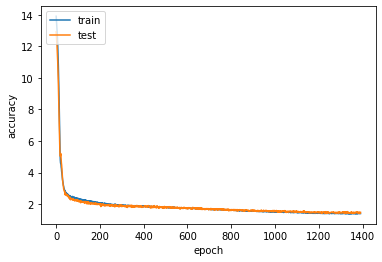

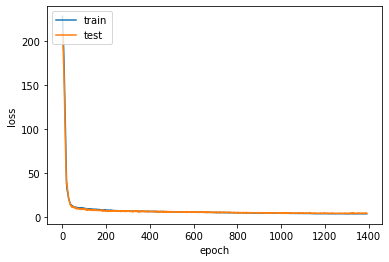

In [4]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
mean_rmses

[1.8161793994903563]

In [28]:
std_rmses

[0.1151273566847427,
 0.17471857257524775,
 0.15687872559715457,
 0.4648023274027273,
 0.31931690589403916]

In [6]:
import pickle

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
save_obj(mean_rmses, "../mean_rmse_dnn_MC.dat")
save_obj(std_rmses, "../std_rmse_dnn_MC.dat")


In [4]:
mc_pred=np.mean(pred,axis=0)
np.mean(mc_pred)

0.02413137

In [5]:
np.mean(np.std(pred,axis=1))

0.015234125

In [544]:
# list1 = [0.01,0.02,0.05,0.1, 0.2, 0.25,0.3,0.35]
# list2 = [5,6,7,8,9,10,11,12,15,20]

# from collections import OrderedDict
# param_grid = OrderedDict(rate = list1, node = list2)
    
# import itertools as it
# allNames = sorted(param_grid)
# combinations = it.product(*(param_grid[Name] for Name in allNames))
# param_combo_list = list(combinations)
# print(len(param_combo_list))
    
# std_list = []
# for it in np.arange(len(param_combo_list)):
#     pred = pass_arg(50, 20, param_combo_list[it])
#     mc_pred=np.mean(pred,axis=0)
#     std_list.append(np.std(pred,axis=1))
# #     print(param_combo_list[it],np.mean(mc_pred_sd))

In [545]:
# stdl = np.array(std_list)
# np.sort(np.mean(stdl,axis=1))

In [546]:
# stdl = np.array(std_list)
# # np.mean(stdl,axis=1)
# argss=np.argsort(np.mean(stdl,axis=1))
# combo = np.array(param_combo_list)
# combo[list(argss)]
# # pred

In [547]:
# mc_pred=np.mean(pred,axis=0)
# mc_pred_sd=np.std(pred,axis=1)
# np.mean(mc_pred_sd)

In [548]:
import pickle

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
save_obj(mc_pred, "../pred_dnn_MC_Xx1.dat")